In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import re 
import uuid
from glob import glob 
import requests
import ast 
import sys
sys.path.append('../src')
from textwrap import dedent

from tqdm.auto import tqdm 
import pandas as pd 
import chromadb
import aiohttp, asyncio 

from llm_utils import call_llm
from src.llm_utils import get_embedding
from client_utils import upsert_cached_image, get_cached_image

def display_image(image_path):
    from PIL import Image
    import matplotlib.pyplot as plt
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

# Load data

In [9]:
df = pd.DataFrame()

img_paths = glob('../images/**/*.png', recursive=True)
df['img_path'] = img_paths
df['prompt'] = df['img_path'].apply(lambda x: x.split('/')[-1].split('.')[0])
df['img_uuid'] = df['img_path'].apply(lambda x: uuid.uuid4()).astype(str)
df[:2]

,img_path,prompt,img_uuid
0,"../images/angel/nude, feet, sofa.png","nude, feet, sofa",8bb783e7-6c5e-494e-9071-d472e11308ee
1,../images/angel/school uniform2.png,school uniform2,0c8979ec-675f-4811-be6a-a6340b43c686


# Get sententes, get nsfgw_tag

In [93]:

async def convert_prompt_to_sentence(diffusion_prompt):
    messages = [
        {"role": "system", "content": "You are a sexual content AI helper system which creates sentences in natural language from set of keywords. Do not add non-existing info to the sentence"},
        {"role": "user", "content": "beach, tits, no clothes"},
        {"role": "assistant", "content": "naked on the beach with beautiful breasts"},
        {"role": "user", "content": "ass, legs, without socks"},
        {"role": "assistant", "content": "gentle display of ass and gentle feet"},
        {"role": "user", "content": "pussy, beautiful"},
        {"role": "assistant", "content": "explisit display of beautiful pussy"},
        {"role": "user", "content": "body, in panties"},
        {"role": "assistant", "content": "showing body with panties"},
        {"role": "user", "content": "hiking"},
        {"role": "assistant", "content": "hiking"},
        {"role": "user", "content": "hiking, mountains, jacket"},
        {"role": "assistant", "content": "hiking in the mountains in jacket"},
        {"role": "user", "content": diffusion_prompt}
    ]
    
    resp = await call_llm(messages)
    if resp['status'] == 'success':
        return resp['answer_text']
    return None

async def convert_sentence_to_nsfw_tag(diffusion_prompt):
    messages = [
        {"role": "system", "content": "You are a sexual content AI helper system which classifies sentense on NSFW content. You output 1 if content is explisit NSFW, and 0 if it is casual or light erotics (no naked intim body parts)"},
        {"role": "user", "content": "naked on the beach with beautiful breasts"},
        {"role": "assistant", "content": "1"},
        {"role": "user", "content": "gentle display of ass and gentle feet"},
        {"role": "assistant", "content": "0"},
        {"role": "user", "content": "explisit display of beautiful pussy"},
        {"role": "assistant", "content": "1"},
        {"role": "user", "content": "showing body with panties"},
        {"role": "assistant", "content": "0"},
        {"role": "user", "content": diffusion_prompt}
    ]
    
    resp = await call_llm(messages)
    if resp['status'] == 'success':
        return resp['answer_text']
    return None


async def process_row(df, idx, row):
    prompt_sentence = await convert_prompt_to_sentence(row['prompt'])
    df.iloc[idx, df.columns.get_loc('prompt_sentence')] = prompt_sentence
    
    nsfw_tag = await convert_sentence_to_nsfw_tag(row['prompt'])
    df.iloc[idx, df.columns.get_loc('nsfw_tag')] = nsfw_tag
    
df['prompt_sentence'] = ""
df['nsfw_tag'] = ""

async with aiohttp.ClientSession() as session:
    tasks = []
    for idx, row in df.iterrows():
        task = asyncio.create_task(process_row(df, idx, row))
        tasks.append(task)
    await asyncio.gather(*tasks)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/openai/_resource.py:40: RuntimeWarning: coroutine 'convert_prompt_to_sentence' was never awaited
  self._get_api_list = client.get_api_list
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/openai/_resource.py:40: RuntimeWarning: coroutine 'convert_sentence_to_nsfw_tag' was never awaited
  self._get_api_list = client.get_api_list
_client.py          :1773 2024-08-15 13:02:02,387 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"
_client.py          :1773 2024-08-15 13:02:02,414 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"
_client.py          :1773 2024-08-15 13:02:02,431 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"
_client.py          :1773 2024-08-15 13:02:02,432 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"
_client.py          :1773 2024-08-15 13:02:02,432 HTTP R

In [94]:
df[:5]

,index,img_path,prompt,img_uuid,prompt_sentence,nsfw_tag,embs
0,0,"../images/angel/nude, feet, sofa.png","nude, feet, sofa",8bb783e7-6c5e-494e-9071-d472e11308ee,nude on the sofa with bare feet,0,"[-0.0030261564534157515, -0.03830080106854439,..."
1,1,../images/angel/school uniform2.png,school uniform2,0c8979ec-675f-4811-be6a-a6340b43c686,school uniform,0,"[0.027347765862941742, -0.03445903956890106, 0..."
2,2,"../images/angel/laying on the bed, legs spread...","laying on the bed, legs spread, showing pussy",0d278bf8-7172-4a28-85a4-21f078e6c2c8,laying on the bed with legs spread showing pussy,1,"[0.019779689610004425, 0.01824391819536686, -0..."
3,3,"../images/angel/sitting on a gaming chair, pus...","sitting on a gaming chair, pussy, naked",ecfc6d71-eaab-4dce-8f74-f226bf5a581d,naked woman sitting on a gaming chair,1,"[0.004512623883783817, -0.0112928980961442, 0...."
4,4,"../images/angel/sitting on a floor, wearing bl...","sitting on a floor, wearing black shoes, black...",f0c406df-3c53-4cfc-b950-06fea78e6a7e,sitting on the floor wearing black shoes and b...,0,"[0.013205001130700111, 0.0017588228220120072, ..."


# Get embs

In [95]:
resp = get_embedding(df['prompt_sentence'].values.tolist())
df['embs'] = resp

_client.py          :1026 2024-08-15 13:02:19,998 HTTP Request: POST https://api.runpod.ai/v2/xoktw5d8vlp238/openai/v1/embeddings "HTTP/1.1 200 OK"


In [96]:
df[:2]

,index,img_path,prompt,img_uuid,prompt_sentence,nsfw_tag,embs
0,0,"../images/angel/nude, feet, sofa.png","nude, feet, sofa",8bb783e7-6c5e-494e-9071-d472e11308ee,nude on the sofa with bare feet,0,"[-0.01972377672791481, -0.025597501546144485, ..."
1,1,../images/angel/school uniform2.png,school uniform2,0c8979ec-675f-4811-be6a-a6340b43c686,school uniform,0,"[0.02506963349878788, -0.019522011280059814, 0..."


In [97]:
df.reset_index().to_feather('../images/angel.feather')

# Add to chroma

In [98]:
persona_name = 'angel'
df = pd.read_feather(f'../images/{persona_name}.feather').reset_index(drop=True)
df[:1]

,level_0,index,img_path,prompt,img_uuid,prompt_sentence,nsfw_tag,embs
0,0,0,"../images/angel/nude, feet, sofa.png","nude, feet, sofa",8bb783e7-6c5e-494e-9071-d472e11308ee,nude on the sofa with bare feet,0,"[-0.01972377672791481, -0.025597501546144485, ..."


In [99]:
df.columns

Index(['level_0', 'index', 'img_path', 'prompt', 'img_uuid', 'prompt_sentence',
       'nsfw_tag', 'embs'],
      dtype='object')

In [100]:
for num, row in tqdm(df.iterrows(), total=df.shape[0]):
    upsert_cached_image(persona=persona_name, img_uuid=row['img_uuid'], img_path=row['img_path'], prompt=row['prompt_sentence'], emb=row['embs'], tags={'nsfw_tag': row['nsfw_tag']})


  0%|          | 0/156 [00:00<?, ?it/s]

Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cached image 200
Added cache

# Query examples

In [101]:
async def query_pipline(diffusion_prompt, user_id, n_results=3):
    prompt_sentence = await convert_prompt_to_sentence(diffusion_prompt)
    print('prompt_sentence:', prompt_sentence)

    nsfw_tag = await convert_sentence_to_nsfw_tag(prompt_sentence)
    print('nsfw_tag:', nsfw_tag)

    res = await get_cached_image(persona=persona_name, prompt=prompt_sentence, tags={'nsfw_tag': nsfw_tag}, user_id=user_id, n_results=n_results)
    if res:
        display_image(res['img_path'])
    return res

In [105]:
res = await query_pipline('hiking, pussy, naked', user_id=5, n_results=1)
res

_client.py          :1773 2024-08-15 13:03:45,092 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


prompt_sentence: naked pussy on a hike


_client.py          :1773 2024-08-15 13:03:45,704 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


nsfw_tag: 1
Query res: {"ids": [["4dc80a79-b09f-4d96-a163-ab0403aa74ea"]], "distances": [[0.5514124035835266]], "embeddings": null, "metadatas": [[{"img_uuid": "4dc80a79-b09f-4d96-a163-ab0403aa74ea", "nsfw_tag": "1", "prompt": "taking a nude selfie with pussy"}]], "documents": [["../images/angel/nude, selfie, pussy2.png"]], "uris": null, "data": null, "included": ["metadatas", "documents", "distances"]}
No images below threshold.


{}

In [107]:
res = await query_pipline('hiking, pussy', user_id=5, n_results=1)
res

_client.py          :1773 2024-08-15 13:04:03,953 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


prompt_sentence: hiking with pussy


_client.py          :1773 2024-08-15 13:04:04,549 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


nsfw_tag: 1
Query res: {"ids": [["4dc80a79-b09f-4d96-a163-ab0403aa74ea"]], "distances": [[0.6565521359443665]], "embeddings": null, "metadatas": [[{"img_uuid": "4dc80a79-b09f-4d96-a163-ab0403aa74ea", "nsfw_tag": "1", "prompt": "taking a nude selfie with pussy"}]], "documents": [["../images/angel/nude, selfie, pussy2.png"]], "uris": null, "data": null, "included": ["metadatas", "documents", "distances"]}
No images below threshold.


{}

_client.py          :1773 2024-08-15 13:03:54,365 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


prompt_sentence: hiking


_client.py          :1773 2024-08-15 13:03:55,022 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


nsfw_tag: 0
Query res: {"ids": [["0c7a4686-ae8a-41ea-ac1b-660869d49f2c"]], "distances": [[0.3905881705186955]], "embeddings": null, "metadatas": [[{"img_uuid": "0c7a4686-ae8a-41ea-ac1b-660869d49f2c", "nsfw_tag": "0", "prompt": "wearing hiking jacket on a hike in the mountains"}]], "documents": [["../images/dressed/hiking jacket, hike, mountains.png"]], "uris": null, "data": null, "included": ["metadatas", "documents", "distances"]}
Succesflly added cached record


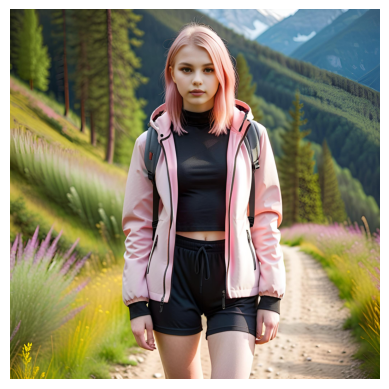

{'img_path': '/Users/nikolaytv/workspace/intim/2.GenAI image cachine service/notebooks/../images/dressed/hiking jacket, hike, mountains.png'}

In [106]:
res = await query_pipline('hiking', user_id=5, n_results=1)
res

_client.py          :1773 2024-08-15 13:06:45,212 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


prompt_sentence: naked in school uniform


_client.py          :1773 2024-08-15 13:06:45,828 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


nsfw_tag: 1
Query res: {"ids": [["698954f0-24bc-4d72-b9d1-aa0ae5d38cd7"]], "distances": [[0.06067446991801262]], "embeddings": null, "metadatas": [[{"img_uuid": "698954f0-24bc-4d72-b9d1-aa0ae5d38cd7", "nsfw_tag": "1", "prompt": "nude in school uniform"}]], "documents": [["../images/angel/nude, school uniform.png"]], "uris": null, "data": null, "included": ["metadatas", "documents", "distances"]}
Succesflly added cached record


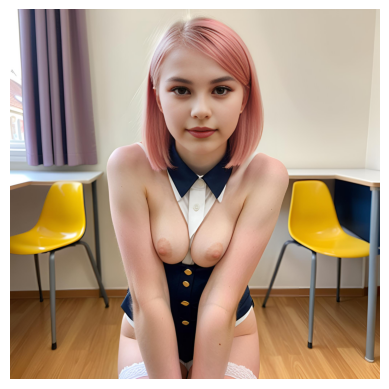

{'img_path': '/Users/nikolaytv/workspace/intim/2.GenAI image cachine service/notebooks/../images/angel/nude, school uniform.png'}

In [108]:
res = await query_pipline('naked, shool uniform', user_id=5, n_results=1)
res

_client.py          :1773 2024-08-15 13:07:11,942 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


prompt_sentence: school uniform


_client.py          :1773 2024-08-15 13:07:12,659 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


nsfw_tag: 0
Query res: {"ids": [["0c8979ec-675f-4811-be6a-a6340b43c686"]], "distances": [[1.263451622435241e-06]], "embeddings": null, "metadatas": [[{"img_uuid": "0c8979ec-675f-4811-be6a-a6340b43c686", "nsfw_tag": "0", "prompt": "school uniform"}]], "documents": [["../images/angel/school uniform2.png"]], "uris": null, "data": null, "included": ["metadatas", "documents", "distances"]}
Succesflly added cached record


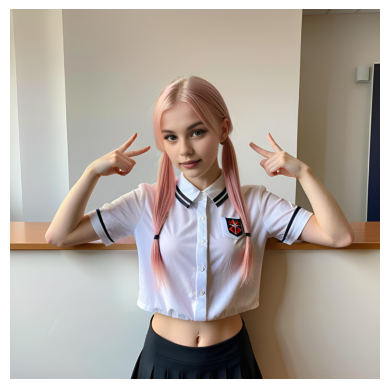

{'img_path': '/Users/nikolaytv/workspace/intim/2.GenAI image cachine service/notebooks/../images/angel/school uniform2.png'}

In [109]:
res = await query_pipline('shool uniform', user_id=4, n_results=1)
res

In [110]:
res = await query_pipline('naked', user_id=4, n_results=1)
res

_client.py          :1773 2024-08-15 13:07:32,526 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


prompt_sentence: naked


_client.py          :1773 2024-08-15 13:07:33,193 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


nsfw_tag: 1
Query res: {"ids": [["51b34197-596b-4cac-86b1-c0d5f76aecde"]], "distances": [[0.47765201330184937]], "embeddings": null, "metadatas": [[{"img_uuid": "51b34197-596b-4cac-86b1-c0d5f76aecde", "nsfw_tag": "1", "prompt": "fully naked on a bed, showing ass"}]], "documents": [["../images/angel/showing ass, sitting on a bed, fully naked.png"]], "uris": null, "data": null, "included": ["metadatas", "documents", "distances"]}
No images below threshold.


{}

_client.py          :1773 2024-08-15 13:08:00,887 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


prompt_sentence: naked ass


_client.py          :1773 2024-08-15 13:08:01,522 HTTP Request: POST http://20.151.65.75:8005/v1/chat/completions "HTTP/1.1 200 OK"


nsfw_tag: 1
Query res: {"ids": [["51b34197-596b-4cac-86b1-c0d5f76aecde"]], "distances": [[0.39137008786201477]], "embeddings": null, "metadatas": [[{"img_uuid": "51b34197-596b-4cac-86b1-c0d5f76aecde", "nsfw_tag": "1", "prompt": "fully naked on a bed, showing ass"}]], "documents": [["../images/angel/showing ass, sitting on a bed, fully naked.png"]], "uris": null, "data": null, "included": ["metadatas", "documents", "distances"]}
Succesflly added cached record


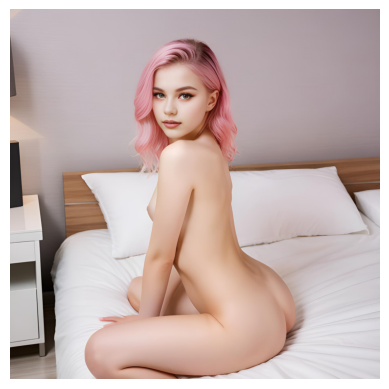

{'img_path': '/Users/nikolaytv/workspace/intim/2.GenAI image cachine service/notebooks/../images/angel/showing ass, sitting on a bed, fully naked.png'}

In [111]:
res = await query_pipline('naked ass', user_id=4, n_results=1)
res